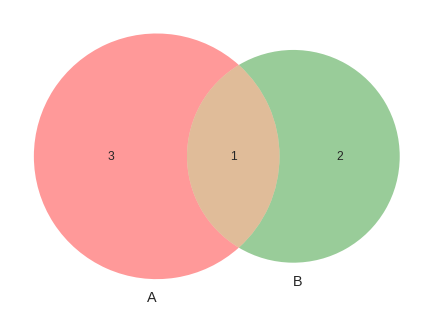

In [2]:
!pip install -q matplotlib-venn

from matplotlib_venn import venn2
_ = venn2(subsets = (3,2,1))

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1FkR7onNyR5z5ko6mY8wtKoJ4L-DkUlfW'
downloaded = drive.CreateFile({'id': file_id})


#DeepDream 학습된 Neural Networks의 Feature를 시각화하고 이를 Input 이미지와 결합하며 환걱적인 이미지를 만들어 내는 알고리즘
#GoogLeNet Neural Networks 구조를 사용할거임.

#라이브러리 Import
from __future__ import print_function
import os

from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

#미리 합습된 GoogLeNet graph 파일 다운로드 하고 이를 로드
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

model_fn = downloaded.GetContentString()

# TensorFlow session 구현 및 model 로드
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input')   # input tensor 정의
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean,0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

# Newral Networks가 이미지 인식을 위해 학습한 내용을 훑어보기 위해서 단순하게, Neural Netwoks의 특정
#Convolution layer의 특정 채널의 Activation이 최대가 되는 값을 이용해서 이미지를 생성.

layers = [op.name for op in graph.get_operations() if op.type == 'Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name + ':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))


# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>" % size)
    return strip_def


def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add()
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0] != '^' else '^' + rename_func(s[1:])
    return res_def


def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


# Visualizing the network graph. Be sure expand the "mixed" nodes to see their
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s: "/".join(s.split('_', 1)))
show_graph(tmp_def)

#navie한 방법으로 feature들을 시각화

# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139  # picking some feature channel to visualize

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224, 224, 3)) + 100.0


def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1) * 255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))


def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a - a.mean()) / max(a.std(), 1e-4) * s + 0.5


def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0" % layer)


def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj)  # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0]  # behold the power of automatic differentiation!

    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input: img})
        # normalizing the gradient, so the same step size should work
        g /= g.std() + 1e-8  # for different layers and networks
        img += g * step
        print(score, end=' ')
    clear_output()
    showarray(visstd(img))


render_naive(T(layer)[:, :, :, channel])

UnicodeDecodeError: ignored

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = 'REPLACE_WITH_YOUR_FILE_ID'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [6]:
from google.colab import files
uploaded = files.upload()



Saving 12.png to 12 (1).png


In [7]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

User uploaded file "12.png" with length 4181 bytes


In [0]:
import pandas as pd
import io
df = pd.read_csv(io.StringIO(uploaded['iris.csv'].decode('utf-8')))
print(df)

In [9]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpw0mj2vzz/pubring.gpg' created
gpg: /tmp/tmpw0mj2vzz/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [0]:
!mkdir -p colabData
!google-drive-ocamlfuse colabData

In [16]:
%%bash
echo "Hello World...!!!" > colabData/hello.txt
ls colabData


ㄴ
소왓 제출물
캡스톤
정보처리 기사 공부
자바스터디
곽승혁(01022403237).xlsx
프로젝트 - 열 차트 1.ods
프로젝트 - 막대 그래프 1.ods
2017학년도 창업소모임 팀원변경신청서.hwp
2018학년도 1학기 캡스톤디자인 과제 지원 신청서(곽승혁).hwp
algo
azk.zip
Copy of Monthly Calendar - Landscape.ods
Copy of Monthly Calendar - Landscape.ods (70b44221)
football-web .zip
hello.txt
IMG_5628.JPG
IMG_5629.JPG
이력서사진(곽승혁).jpg
KakaoTalk_20171123_222436445.jpg
KakaoTalk_20171123_222436445.odt
mb3-setup-consumer-3.1.2.1733-1.0.141-1.0.2092.exe
mzk.zip
제본 완료 보고 .odt
여수 여행 기획서.odt
티스토리 이미지.odt
소프트웨어 제본.odt
시스템구성도.odt
사업계획서_참고자료.pdf
새파일.txt


In [0]:
f = open("colabData/새파일.txt", 'w')
f.close()

In [18]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

height = 512
width = 512

##################################################

#        DEFINING LOSS AND OTHER FUNCTIONS       #

##################################################

def content_loss(content, combination):
    return backend.sum(backend.square(combination-content))

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S-C))/(4.*(channels**2)*(size**2))

def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a+b, 1.25))

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

def postprocess_array(x):
    x = x.reshape((height, width, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

##################################################

#           PREPROCESSING INPUT IMAGES           #

##################################################

content_image_path = 'colabData/background.jpg'
content_image = Image.open(content_image_path)
og_size = content_image.size
content_image = content_image.resize((width, height))

style_image_path = 'colabData/vangogh.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))

content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)

#preparation for vgg use

content_array = preprocess_input(content_array)
style_array = preprocess_input(style_array)

content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

input_tensor = backend.concatenate([content_image, style_image, combination_image], axis=0)

model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

##################################################

#            TUNING THE HYPERPARAMETERS          #

##################################################

layers = dict([(layer.name, layer.output) for layer in model.layers])

content_weight = 0.05
style_weight = 7.0
total_variation_weight = 1.0

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)

loss += content_weight * content_loss(content_image_features, combination_features)

feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight/len(feature_layers)) * sl

loss += total_variation_weight * total_variation_loss(combination_image)

grads = backend.gradients(loss, combination_image)

outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time-start_time))

    x = postprocess_array(x)

    res = Image.fromarray(x)
    res = res.resize(og_size)
    save_path = 'colabData/iter' + str(i) + '.jpg'
    res.save(save_path)

58892288/58889256 [==============================] - 1s 0us/step
Start of iteration 0
Current loss value: 88446750000.0
Iteration 0 completed in 24s
Start of iteration 1
Current loss value: 111206020000.0
Iteration 1 completed in 19s
Start of iteration 2
Current loss value: 85900526000.0
Iteration 2 completed in 19s
Start of iteration 3
Current loss value: 83030475000.0
Iteration 3 completed in 19s
Start of iteration 4
Current loss value: 89773350000.0
Iteration 4 completed in 19s
Start of iteration 5
Current loss value: 65007227000.0
Iteration 5 completed in 19s
Start of iteration 6
Current loss value: 72197100000.0
Iteration 6 completed in 20s
Start of iteration 7
Current loss value: 66564200000.0
Iteration 7 completed in 19s
Start of iteration 8
Current loss value: 79977720000.0
Iteration 8 completed in 19s
Start of iteration 9
Current loss value: 84878780000.0
Iteration 9 completed in 19s


2번째 style transfer

In [24]:
"""Neural Style Transfer"""
# Importing all the required packages
from __future__ import print_function
from PIL import Image
import time
import numpy as np
import argparse

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

# Dimensions of the images
height = 512
width = 512
'''
# Passing image addresses as arguments
parser = argparse.ArgumentParser(description="Neural Style Transfer with Keras.")
parser.add_argument('colabData/background.jpg', metavar='base', type=str, help='Path to the Content Image')
parser.add_argument('colabData/vangogh.jpg', metavar='ref',
                    type=str, help='Path to the Style Image')
args = parser.parse_args()
'''
# Import Images and Resize them
#content_image_path = args.content_image_path
content_image_path = 'colabData/ys.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))

#style_image_path = args.style_image_path
style_image_path = 'colabData/이중섭.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))

content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

input_tensor = backend.concatenate([content_image, style_image, combination_image], axis=0)

model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
layers = dict([(layer.name, layer.output) for layer in model.layers])
# print(layers)

content_weight = 0.025
style_weight = 9.0
total_variation_weight = 1.0
loss = backend.variable(0.)

# Content Loss


def content_loss(content, combinaton):
    return backend.sum(backend.square(combinaton - content))


layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
# Content loss appended to the loss variable
loss += content_weight * content_loss(content_image_features,
                                      combination_features)

# Style Loss


def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram


def style_loss(style, combinaton):
    S = gram_matrix(style)
    C = gram_matrix(combinaton)
    channels = 3
    size = width * height
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


feature_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

# Total Variation Loss (Content + Style)


def total_variation_loss(x):
    a = backend.square(x[:, :height - 1, :width - 1, :] - x[:, 1:, :width - 1, :])
    b = backend.square(x[:, :height - 1, :width - 1, :] - x[:, :height - 1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))


loss += total_variation_weight * total_variation_loss(combination_image)

# Solving the optimisation problem
grads = backend.gradients(loss, combination_image)

outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)


def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values


evaluator = Evaluator()

x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 101

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    if i % 10 == 0:
        # Deprocess the image
        x = x.reshape((height, width, 3))
        x = x[:, :, ::-1]
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        x = np.clip(x, 0, 255).astype('uint8')
        img = Image.fromarray(x)
        img.save('colabData/캡스톤/resultys_%d.png' % (i))

Start of iteration 0
Current loss value: 204464650000.0
Iteration 0 completed in 19s
Start of iteration 1
Current loss value: 430024500000.0
Iteration 1 completed in 18s
Start of iteration 2
Current loss value: 95108300000.0
Iteration 2 completed in 19s
Start of iteration 3
Current loss value: 68752000000.0
Iteration 3 completed in 19s
Start of iteration 4
Current loss value: 55188250000.0
Iteration 4 completed in 19s
Start of iteration 5
Current loss value: 46640950000.0
Iteration 5 completed in 19s
Start of iteration 6
Current loss value: 41911886000.0
Iteration 6 completed in 19s
Start of iteration 7
Current loss value: 39099474000.0
Iteration 7 completed in 19s
Start of iteration 8
Current loss value: 37053633000.0
Iteration 8 completed in 19s
Start of iteration 9
Current loss value: 35698520000.0
Iteration 9 completed in 19s
Start of iteration 10
Current loss value: 34887135000.0
Iteration 10 completed in 19s
Start of iteration 11
Current loss value: 278997500000.0
Iteration 11 co

Current loss value: 37825835000.0
Iteration 45 completed in 19s
Start of iteration 46
Current loss value: 36129346000.0
Iteration 46 completed in 19s
Start of iteration 47
Current loss value: 35052330000.0
Iteration 47 completed in 19s
Start of iteration 48
Current loss value: 34524307000.0
Iteration 48 completed in 19s
Start of iteration 49
Current loss value: 34130172000.0
Iteration 49 completed in 19s
Start of iteration 50
Current loss value: 33883605000.0
Iteration 50 completed in 19s
Start of iteration 51
Current loss value: 267103960000.0
Iteration 51 completed in 19s
Start of iteration 52
Current loss value: 65590333000.0
Iteration 52 completed in 19s
Start of iteration 53
Current loss value: 46793190000.0
Iteration 53 completed in 19s
Start of iteration 54
Current loss value: 40641737000.0
Iteration 54 completed in 19s
Start of iteration 55
Current loss value: 37905633000.0
Iteration 55 completed in 20s
Start of iteration 56
Current loss value: 36214964000.0
Iteration 56 comple

Current loss value: 33912189000.0
Iteration 90 completed in 19s
Start of iteration 91
Current loss value: 247247370000.0
Iteration 91 completed in 19s
Start of iteration 92
Current loss value: 78691660000.0
Iteration 92 completed in 19s
Start of iteration 93
Current loss value: 50248258000.0
Iteration 93 completed in 19s
Start of iteration 94
Current loss value: 41245130000.0
Iteration 94 completed in 19s
Start of iteration 95
Current loss value: 38444940000.0
Iteration 95 completed in 19s
Start of iteration 96
Current loss value: 36494512000.0
Iteration 96 completed in 19s
Start of iteration 97
Current loss value: 35576627000.0
Iteration 97 completed in 19s
Start of iteration 98
Current loss value: 34816745000.0
Iteration 98 completed in 19s
Start of iteration 99
Current loss value: 34356986000.0
Iteration 99 completed in 19s
Start of iteration 100
Current loss value: 34018568000.0
Iteration 100 completed in 19s
